Pandas Library Import

In [ ]:
import pandas as pd

Dataset Import

In [ ]:
names = (
    'nama',
    'nik',
    'pekerjaan',
    'tempat_kerja',
    'subsektor',
    'alamat_kerja',
    'no_hp',
    'alamat_tinggal',
    'kab/kota'
)

categorical = set((
    'nama',
    'nik',
    'pekerjaan',
    'tempat_kerja',
    'subsektor',
    'alamat_kerja',
    'no_hp',
    'alamat_tinggal',
    'kab/kota'
))

df = pd.read_csv("dataset.csv", sep=",", header=None,names=names, index_col=False, engine='python')

In [ ]:
df.head()

,nama,nik,pekerjaan,tempat_kerja,subsektor,alamat_kerja,no_hp,alamat_tinggal,kab/kota
0,MUSTHOFIYAH,3321124411970000,Karyawan,Java kitchen,KULINER,Restoran java kitchen pondok indah\nmall 2 lt....,087845671424,Demak(jln.kopro banjir no.1\nRt.8/Rw.11 kebayo...,05. Kabupaten Demak
1,DWI MARFIANA,3321115432630000,Pemilik,Batik KarangMlati,KRIYA,Jalan Demak Bonang KM 5,081326186882,Jalan Demak Bonang KM 5,05. Kabupaten Demak
2,IRSYAD,3172010309851000,Pemilik,Zem Silver,"KRIYA, DESAIN PRODUK","Desa Mijen, Kecamatan Kebonagung",082313130261,"Desa Mijen, Kecamatan Kebonagung",05. Kabupaten Demak
3,TRIA AGUNG AS,3321061605950010,Pemilik,Mulya mandiri,"FASHION, DESAIN PRODUK",Ds.getas kec.wonosalam rt 06 rw04 kab.Demak,082133670896,Ds.getas kec.wonosalam rt 06 rw04 kab.Demak,05. Kabupaten Demak
4,TRIYANTO,3321141312800000,Pemilik,Triyanto (pengrajin logam),"KRIYA, DESAIN PRODUK","Mijen selatan, kecamatan Kebonagung",089647568187,"Mijen selatan, kecamatan Kebonagung",05. Kabupaten Demak


In [ ]:
for name in categorical:
    df[name] = df[name].astype('category')

Dataset Pre-Processing

In [ ]:
df['tempat_kerja_cat'] = df['tempat_kerja'].cat.codes
df['alamat_tinggal_cat'] = df['alamat_tinggal'].cat.codes
df['alamat_kerja_cat'] = df['alamat_kerja'].cat.codes


df.head()

,nama,nik,pekerjaan,tempat_kerja,subsektor,alamat_kerja,no_hp,alamat_tinggal,kab/kota,tempat_kerja_cat,alamat_tinggal_cat,alamat_kerja_cat
0,MUSTHOFIYAH,3321124411970000,Karyawan,Java kitchen,KULINER,Restoran java kitchen pondok indah\nmall 2 lt....,087845671424,Demak(jln.kopro banjir no.1\nRt.8/Rw.11 kebayo...,05. Kabupaten Demak,12,3,48
1,DWI MARFIANA,3321115432630000,Pemilik,Batik KarangMlati,KRIYA,Jalan Demak Bonang KM 5,081326186882,Jalan Demak Bonang KM 5,05. Kabupaten Demak,1,11,11
2,IRSYAD,3172010309851000,Pemilik,Zem Silver,"KRIYA, DESAIN PRODUK","Desa Mijen, Kecamatan Kebonagung",082313130261,"Desa Mijen, Kecamatan Kebonagung",05. Kabupaten Demak,38,5,2
3,TRIA AGUNG AS,3321061605950010,Pemilik,Mulya mandiri,"FASHION, DESAIN PRODUK",Ds.getas kec.wonosalam rt 06 rw04 kab.Demak,082133670896,Ds.getas kec.wonosalam rt 06 rw04 kab.Demak,05. Kabupaten Demak,16,10,9
4,TRIYANTO,3321141312800000,Pemilik,Triyanto (pengrajin logam),"KRIYA, DESAIN PRODUK","Mijen selatan, kecamatan Kebonagung",089647568187,"Mijen selatan, kecamatan Kebonagung",05. Kabupaten Demak,32,24,38


Get Spans

In [ ]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [ ]:
full_spans = get_spans(df, df.index)
full_spans

{'alamat_kerja': 62,
 'alamat_kerja_cat': 61,
 'alamat_tinggal': 71,
 'alamat_tinggal_cat': 70,
 'kab/kota': 1,
 'nama': 139,
 'nik': 140,
 'no_hp': 127,
 'pekerjaan': 15,
 'subsektor': 15,
 'tempat_kerja': 44,
 'tempat_kerja_cat': 43}

K-Anonymity Functions

In [ ]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [ ]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [ ]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
feature_columns = ['alamat_kerja_cat','alamat_tinggal_cat']
sensitive_column = 'subsektor'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [ ]:
# we get the number of partitions that were created
len(finished_partitions)

19

Matplotlib Library Import

In [ ]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

Partition of Dataset Visualization

In [ ]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [ ]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [ ]:
# let's see how our rects look like
rects[:10]

[((0.0, 0.0), (13.0, 32.0)),
 ((13.0, 0.0), (20.0, 5.0)),
 ((13.0, 12.0), (16.0, 23.0)),
 ((20.0, 0.0), (25.0, 1.0)),
 ((25.0, 0.0), (30.0, 1.0)),
 ((30.0, 0.0), (35.0, 14.0)),
 ((36.0, 2.0), (49.0, 17.0)),
 ((35.0, 17.0), (41.0, 28.0)),
 ((41.0, 23.0), (55.0, 30.0)),
 ((13.0, 34.0), (14.0, 45.0))]

In [ ]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

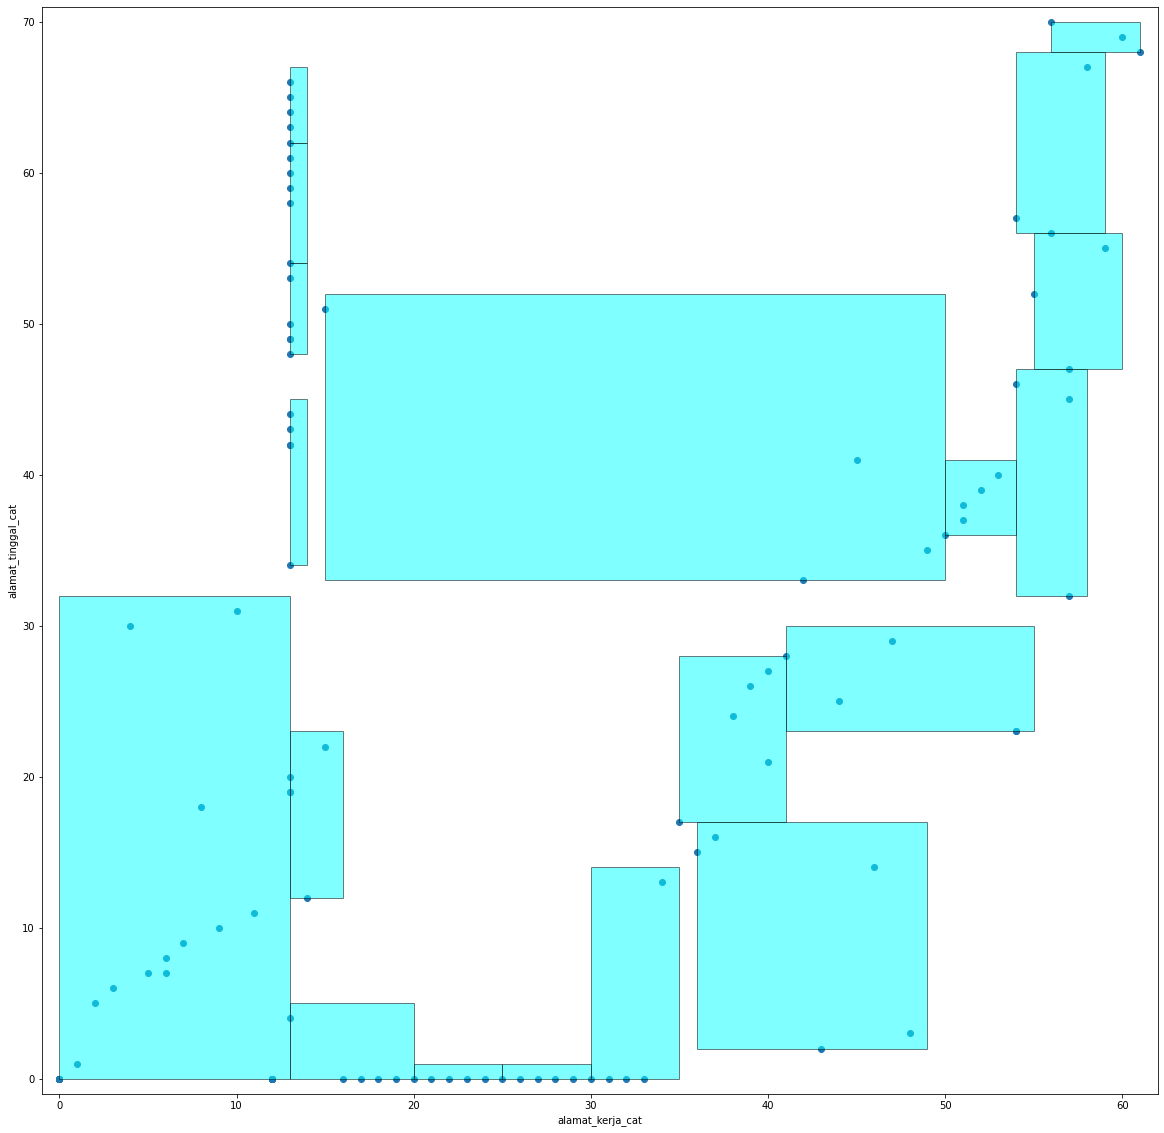

In [ ]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='aqua')
pl.scatter(df[column_x], df[column_y])
pl.show()

Building Anonymized Dataset

In [ ]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [ ]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [ ]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


In [ ]:
dfn.to_csv('anonymized_dataset.csv', index=False)
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,alamat_kerja_cat,alamat_tinggal_cat,subsektor,count
0,3.254237,2.423729,Daya Tarik Wisata,1
1,3.254237,2.423729,Desa Wisata,1
2,3.254237,2.423729,FASHION,3
3,3.254237,2.423729,"FASHION, DESAIN PRODUK",1
4,3.254237,2.423729,Hiburan/ Rekreasi,1
5,3.254237,2.423729,KRIYA,2
6,3.254237,2.423729,"KRIYA, DESAIN PRODUK",1
7,3.254237,2.423729,Kuliner,47
8,3.254237,2.423729,Pemandu Wisata,1
9,3.254237,2.423729,SENI PERTUNJUKAN,1
